**João Lucas Lage Gonçalves**

**2020054552**

**Link do vídeo:** https://drive.google.com/file/d/1_inIPGAS_HscWh-acjRV_CQOu-D5pLP-/view?usp=sharing

# Descrição


Nos últimos anos o uso de dados nos esportes vem crescendo muito. O uso de modelos de aprendizado de máquina já é uma realidade em vários esportes, inclusive o futebol, para várias finalidades, desde administrativas até esportivas, como por exemplo análise de desempenho dos jogadores.

Nesse trabalho irei implementar o VAEP (Valuing Actions by Estimating Probabilities) um framework proposto no artigo Actions Speak Louder than Goals: Valuing Player Actions in Soccer. Esse framework consiste em calcular para todas as ações (passes,chutes,dribles) realizadas em campo duas probabilidades: a probabilidade de aquela ação gerar um gol para seu próprio time nas próximas 10 ações e a probabilidade de gerar um gol para o adversário nas próximas 10 ações.
Após calcular essas probabilidadaes. Essas probabilidades geram duas métricas: 
 . Valor Ofensivo: o delta da probabilidade de marcar um gol em relação a ação anterior
 . Valor Defensivo: o delta da probabilidade de sofrer um gol em relação a ação anterior, de forma invertida, ou seja, se a probabilidade aumentar o valor é negativo, se diminuir é positivo
 
Com essas duas métricas, calculamos então o valor final, o VAEP, sendo ele a soma do Valor Ofensivo com o Valor Defensivo. O VAEP serve principlamente para avaliar jogadores para além das métricas clássicas de gols e assistências, ajudando os times a encontrarem mais facilmente jogadores que impactam positivamente ou negativamente o jogo de forma não tão obvia.

In [1]:
!pip install socceraction
!pip install --upgrade bottleneck

In [2]:
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import brier_score_loss, log_loss, roc_auc_score, accuracy_score
import xgboost as xgb

import socceraction.spadl as spadl
from socceraction.data.wyscout import PublicWyscoutLoader
from socceraction.vaep import features as ft
import socceraction.vaep.labels as lb
import socceraction.vaep.formula as vaepformula


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Carregar os dados

In [3]:
DATA_DIR = 'data'
WYL = PublicWyscoutLoader(root=DATA_DIR)
TRAIN_COMPETITIONS = ['German first division', 'Italian first division', 'French first division', 'Spanish first division', 'English first division']
TEST_COMPETITIONS = ['World Cup', 'European Championship']

competitions = WYL.competitions()

train_competions = competitions[competitions.competition_name.isin(TRAIN_COMPETITIONS)]
test_competions = competitions[competitions.competition_name.isin(TEST_COMPETITIONS)]

train_games = pd.concat([
    WYL.games(competition_id=competition.competition_id, season_id=competition.season_id)
    for competition in train_competions.itertuples()
])

test_games = pd.concat([
    WYL.games(competition_id=competition.competition_id, season_id=competition.season_id)
    for competition in test_competions.itertuples()
])

test_games.head()


,game_id,competition_id,season_id,game_date,game_day,home_team_id,away_team_id
0,1694440,102,9291,2016-07-10 19:00:00,0,9905,4418
1,1694439,102,9291,2016-07-07 19:00:00,0,3148,4418
2,1694438,102,9291,2016-07-06 19:00:00,0,9905,10682
3,1694437,102,9291,2016-07-03 19:00:00,0,4418,7839
4,1694436,102,9291,2016-07-02 19:00:00,0,3148,3757


In [4]:
games_verbose = list(train_games.itertuples())

training_actions = []
for game in tqdm(games_verbose, desc="Converting training games to SPADL ({} games)".format(len(games_verbose)), total=len(games_verbose)):
    events = WYL.events(game.game_id)
    events = events.rename(columns={'id': 'event_id', 'eventId': 'type_id', 'subEventId': 'subtype_id',
                            'teamId': 'team_id', 'playerId': 'player_id', 'matchId': 'game_id'})
    actions_game = spadl.wyscout.convert_to_actions(events, game.home_team_id)
    actions_game = spadl.play_left_to_right(actions=actions_game, home_team_id=game.home_team_id)
    actions_game = spadl.add_names(actions_game)
    actions_game['home_team_id'] = game.home_team_id
    training_actions.append(actions_game)

training_df = pd.concat(training_actions).reset_index(drop=True)

Converting training games to SPADL (1826 games): 100%|██████████| 1826/1826 [17:15<00:00,  1.76it/s] 


In [5]:
games_verbose = list(test_games.itertuples())

test_actions = []
for game in tqdm(games_verbose, desc="Converting test games to SPADL ({} games)".format(len(games_verbose)), total=len(games_verbose)):
    events = WYL.events(game.game_id)
    events = events.rename(columns={'id': 'event_id', 'eventId': 'type_id', 'subEventId': 'subtype_id',
                            'teamId': 'team_id', 'playerId': 'player_id', 'matchId': 'game_id'})
    actions_game = spadl.wyscout.convert_to_actions(events, game.home_team_id)
    actions_game = spadl.play_left_to_right(actions=actions_game, home_team_id=game.home_team_id)
    actions_game = spadl.add_names(actions_game)
    actions_game['home_team_id'] = game.home_team_id
    test_actions.append(actions_game)

test_df = pd.concat(test_actions).reset_index(drop=True)

Converting test games to SPADL (115 games): 100%|██████████| 115/115 [01:12<00:00,  1.58it/s]


In [6]:
players = pd.read_json(DATA_DIR+'\players.json')
players.head()

,passportArea,weight,firstName,middleName,lastName,currentTeamId,birthDate,height,role,birthArea,wyId,foot,shortName,currentNationalTeamId
0,"{'name': 'Turkey', 'id': '792', 'alpha3code': ...",78,Harun,,Tekin,4502,1989-06-17,187,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'Turkey', 'id': '792', 'alpha3code': ...",32777,right,H. Tekin,4687
1,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",73,Malang,,Sarr,3775,1999-01-23,182,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393228,left,M. Sarr,4423
2,"{'name': 'France', 'id': '250', 'alpha3code': ...",72,Over,,Mandanda,3772,1998-10-26,176,"{'code2': 'GK', 'code3': 'GKP', 'name': 'Goalk...","{'name': 'France', 'id': '250', 'alpha3code': ...",393230,,O. Mandanda,null
3,"{'name': 'Senegal', 'id': '686', 'alpha3code':...",82,Alfred John Momar,,N'Diaye,683,1990-03-06,187,"{'code2': 'MD', 'code3': 'MID', 'name': 'Midfi...","{'name': 'France', 'id': '250', 'alpha3code': ...",32793,right,A. N'Diaye,19314
4,"{'name': 'France', 'id': '250', 'alpha3code': ...",84,Ibrahima,,Konat\u00e9,2975,1999-05-25,192,"{'code2': 'DF', 'code3': 'DEF', 'name': 'Defen...","{'name': 'France', 'id': '250', 'alpha3code': ...",393247,right,I. Konat\u00e9,null


In [7]:
teams = pd.read_json(DATA_DIR+'\\teams.json')
teams.head()

,city,name,wyId,officialName,area,type
0,Newcastle upon Tyne,Newcastle United,1613,Newcastle United FC,"{'name': 'England', 'id': '0', 'alpha3code': '...",club
1,Vigo,Celta de Vigo,692,Real Club Celta de Vigo,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
2,Barcelona,Espanyol,691,Reial Club Deportiu Espanyol,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
3,Vitoria-Gasteiz,Deportivo Alav\u00e9s,696,Deportivo Alav\u00e9s,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club
4,Valencia,Levante,695,Levante UD,"{'name': 'Spain', 'id': '724', 'alpha3code': '...",club


# Tratamento de dados

In [8]:
test_games['game_date'] = pd.to_datetime(test_games['game_date'])
train_games['game_date'] = pd.to_datetime(train_games['game_date'])

test_date = test_games['game_date'].min()
train_date = train_games['game_date'].min()

print(f"Train date: {train_date}")
print(f"Test date: {test_date}")

Train date: 2017-08-04 18:45:00
Test date: 2016-06-10 19:00:00


In [9]:
players['player_name'] = players['firstName'] + ' ' + players['lastName']
players['player_country'] = players['passportArea'].apply(lambda x: x['name'] if x is not None else None)
players['birthDate'] = pd.to_datetime(players['birthDate'])
players['train_age'] = (train_date - players['birthDate']).dt.days // 365
players['test_age'] = (test_date - players['birthDate']).dt.days // 365

players['player_name'] = players['player_name'].str.decode('unicode-escape')
players['player_country'] = players['player_country'].str.decode('unicode-escape')
players['shortName'] = players['shortName'].str.decode('unicode-escape')
players = players.rename(columns={'wyId': 'player_id', 'currentTeamId': 'team_id'})

players = players[['player_id', 'player_name', 'shortName', 'player_country', 'train_age', 'test_age', 'team_id']]

players.head()

,player_id,player_name,shortName,player_country,train_age,test_age,team_id
0,32777,Harun Tekin,H. Tekin,Turkey,28,27,4502
1,393228,Malang Sarr,M. Sarr,Senegal,18,17,3775
2,393230,Over Mandanda,O. Mandanda,France,18,17,3772
3,32793,Alfred John Momar N'Diaye,A. N'Diaye,Senegal,27,26,683
4,393247,Ibrahima Konaté,I. Konaté,France,18,17,2975


In [10]:
teams['team_country'] = teams['area'].apply(lambda x: x['name'] if x is not None else None)
teams['name'] = teams['name'].str.decode('unicode-escape')
teams['team_country'] = teams['team_country'].str.decode('unicode-escape')

teams = teams.rename(columns={'wyId': 'team_id', 'name': 'team_name'})

teams = teams[['team_id', 'team_name', 'team_country']]

teams.head()

,team_id,team_name,team_country
0,1613,Newcastle United,England
1,692,Celta de Vigo,Spain
2,691,Espanyol,Spain
3,696,Deportivo Alavés,Spain
4,695,Levante,Spain


# Feature Engeneering

In [11]:
def createFeatures(actions):
    xfns = [
        ft.actiontype_onehot,
        ft.bodypart_onehot,
        ft.result_onehot,
        ft.goalscore,
        ft.startlocation,
        ft.endlocation,
        ft.movement,
        ft.space_delta,
        ft.startpolar,
        ft.endpolar,
        ft.team,
        ft.time,
        ft.time_delta
    ]

    features = []
    for game in tqdm(actions.game_id.unique(), desc="Creating features"):
        actions_game = actions[actions.game_id==game].reset_index(drop=True)
        match_states = ft.gamestates(actions=actions_game)
        match_features = pd.concat([fn(match_states) for fn in xfns], axis=1)
        features.append(match_features)

    features = pd.concat(features).reset_index(drop=True)
    return features

In [12]:
training_features = createFeatures(training_df)
test_features = createFeatures(test_df)

test_features.head()

Creating features: 100%|██████████| 115/115 [00:11<00:00, 10.19it/s]


,actiontype_pass_a0,actiontype_cross_a0,actiontype_throw_in_a0,actiontype_freekick_crossed_a0,actiontype_freekick_short_a0,actiontype_corner_crossed_a0,actiontype_corner_short_a0,actiontype_take_on_a0,actiontype_foul_a0,actiontype_tackle_a0,...,time_seconds_a0,time_seconds_overall_a0,period_id_a1,time_seconds_a1,time_seconds_overall_a1,period_id_a2,time_seconds_a2,time_seconds_overall_a2,time_delta_1,time_delta_2
0,True,False,False,False,False,False,False,False,False,False,...,4.782709,4.782709,1.0,4.782709,4.782709,1.0,4.782709,4.782709,0.000000,0.000000
1,True,False,False,False,False,False,False,False,False,False,...,6.973876,6.973876,1.0,4.782709,4.782709,1.0,4.782709,4.782709,2.191167,2.191167
2,True,False,False,False,False,False,False,False,False,False,...,9.531543,9.531543,1.0,6.973876,6.973876,1.0,4.782709,4.782709,2.557667,4.748834
3,True,False,False,False,False,False,False,False,False,False,...,10.575710,10.575710,1.0,9.531543,9.531543,1.0,6.973876,6.973876,1.044167,3.601834
4,True,False,False,False,False,False,False,False,False,False,...,13.624168,13.624168,1.0,10.575710,10.575710,1.0,9.531543,9.531543,3.048458,4.092625


# Gerando Labels

In [13]:
def createLabels(actions):
    yfns = [
        lb.scores,
        lb.concedes
    ]

    labels = []
    for game in tqdm(actions.game_id.unique(), desc="Creating labels"):
        actions_game = actions[actions.game_id==game].reset_index(drop=True)
        labels.append(pd.concat([fn(actions=actions_game) for fn in yfns], axis=1))

    labels = pd.concat(labels).reset_index(drop=True)
    return labels

In [14]:
training_labels = createLabels(actions=training_df)
test_labels = createLabels(actions=test_df)

test_labels.head()

Creating labels:   0%|          | 0/1826 [00:00<?, ?it/s]

Creating labels: 100%|██████████| 115/115 [00:04<00:00, 28.72it/s]


,scores,concedes
0,False,False
1,False,False
2,False,False
3,False,False
4,False,False


# Model Creation   

In [15]:
class XGBoostClassifier():
    def __init__(self, n_estimators, max_depth, n_jobs, verbosity):
        self.model = xgb.XGBClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs, verbosity=verbosity)
    
    def fit(self, X, y):    
        self.model.fit(X, y)
    
    def predict_proba(self, X):
        return self.model.predict_proba(X)[:, 1].reshape(-1, 1)
    
    def predict(self, X):
        return self.model.predict(X).reshape(-1, 1)
    
    def evaluate(self, X, y):
        y_pred = self.predict(X)
        y_proba = self.predict_proba(X)
        y_true = y.values
        
        metrics = {}
        metrics = {
            "brier": brier_score_loss(y_true, y_proba),
            "log_loss": log_loss(y_true, y_proba),
            "roc_auc": roc_auc_score(y_true, y_proba),
            "accuracy": accuracy_score(y_true, y_pred)
        }
        return metrics

# Execução

In [16]:
list_n_esn_estimators = [25,50,100]
list_max_depth = [3,5,9]
verbosity=1
n_jobs=-3

In [17]:
metrics_list = []

In [18]:
for n_estimators in list_n_esn_estimators:
    for max_depth in list_max_depth:
        for label in test_labels.columns:

            model_path = f"./models/xgbc_{label}_est{n_estimators}_dph{max_depth}.pkl"

            if os.path.exists(model_path):
                print(f"Loading model {model_path}")
                xgbc = XGBoostClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs, verbosity=verbosity)
                xgbc.model.load_model(model_path)
                metrics = xgbc.evaluate(test_features, test_labels[label])
            else:
                print(f"Training model xgbc_{label}_est{n_estimators}_dph{max_depth}")
                xgbc = XGBoostClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs, verbosity=verbosity)
                xgbc.fit(training_features, training_labels[label])
                metrics = xgbc.evaluate(test_features, test_labels[label])

                xgbc.model.save_model(model_path)

            metrics_list.append({
                "model": f"xgbc_{label}_est{n_estimators}_dph{max_depth}",
                "brier": metrics["brier"],
                "log_loss": metrics["log_loss"],
                "roc_auc": metrics["roc_auc"],
                "accuracy": metrics["accuracy"]
            })       

Training model xgbc_scores_est25_dph3


c:\Users\jllgo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:23:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Training model xgbc_concedes_est25_dph3


c:\Users\jllgo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:23:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Training model xgbc_scores_est25_dph5


c:\Users\jllgo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:23:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Training model xgbc_concedes_est25_dph5


c:\Users\jllgo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:24:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Training model xgbc_scores_est25_dph9


c:\Users\jllgo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:24:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Training model xgbc_concedes_est25_dph9


c:\Users\jllgo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:24:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Training model xgbc_scores_est50_dph3


c:\Users\jllgo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:25:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Training model xgbc_concedes_est50_dph3


c:\Users\jllgo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:25:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Training model xgbc_scores_est50_dph5


c:\Users\jllgo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:26:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Training model xgbc_concedes_est50_dph5


c:\Users\jllgo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:26:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Training model xgbc_scores_est50_dph9


c:\Users\jllgo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:27:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Training model xgbc_concedes_est50_dph9


c:\Users\jllgo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:27:46] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Training model xgbc_scores_est100_dph3


c:\Users\jllgo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:28:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Training model xgbc_concedes_est100_dph3


c:\Users\jllgo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:29:02] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Training model xgbc_scores_est100_dph5


c:\Users\jllgo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:29:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Training model xgbc_concedes_est100_dph5


c:\Users\jllgo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:30:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Training model xgbc_scores_est100_dph9


c:\Users\jllgo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:31:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


Training model xgbc_concedes_est100_dph9


c:\Users\jllgo\anaconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [09:32:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\c_api\c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


# Avaliação

In [20]:
# plot each metric in a bar chart
metrics_df = pd.DataFrame(metrics_list)

scores_metrics = metrics_df[metrics_df.model.str.contains('scores')].reset_index(drop=True)
concedes_metrics = metrics_df[metrics_df.model.str.contains('concedes')].reset_index(drop=True)

scores_metrics


,model,brier,log_loss,roc_auc,accuracy
0,xgbc_scores_est25_dph3,0.011874,0.061613,0.749589,0.987707
1,xgbc_scores_est25_dph5,0.011902,0.061411,0.755948,0.987575
2,xgbc_scores_est25_dph9,0.011981,0.061815,0.753274,0.987554
3,xgbc_scores_est50_dph3,0.011808,0.061263,0.754570,0.987846
4,xgbc_scores_est50_dph5,0.011827,0.061182,0.757448,0.987777
5,xgbc_scores_est50_dph9,0.011930,0.062236,0.746024,0.987652
6,xgbc_scores_est100_dph3,0.011775,0.061108,0.755574,0.987881
7,xgbc_scores_est100_dph5,0.011776,0.061122,0.758475,0.987867
8,xgbc_scores_est100_dph9,0.012030,0.063577,0.734116,0.987631


In [21]:
def plot_metrics(df, label, metric):
    plt.figure(figsize=(14, 7))

    color = "blue" if label=="scores" else "orange"

    sns.barplot(x="model", y=metric, data=df, color=color, label=label)
    plt.xticks(rotation=90)
    plt.title(f'Comparison of {metric} between Models')


    plt.yscale('log', base=10)

    plt.legend()
    plt.show()

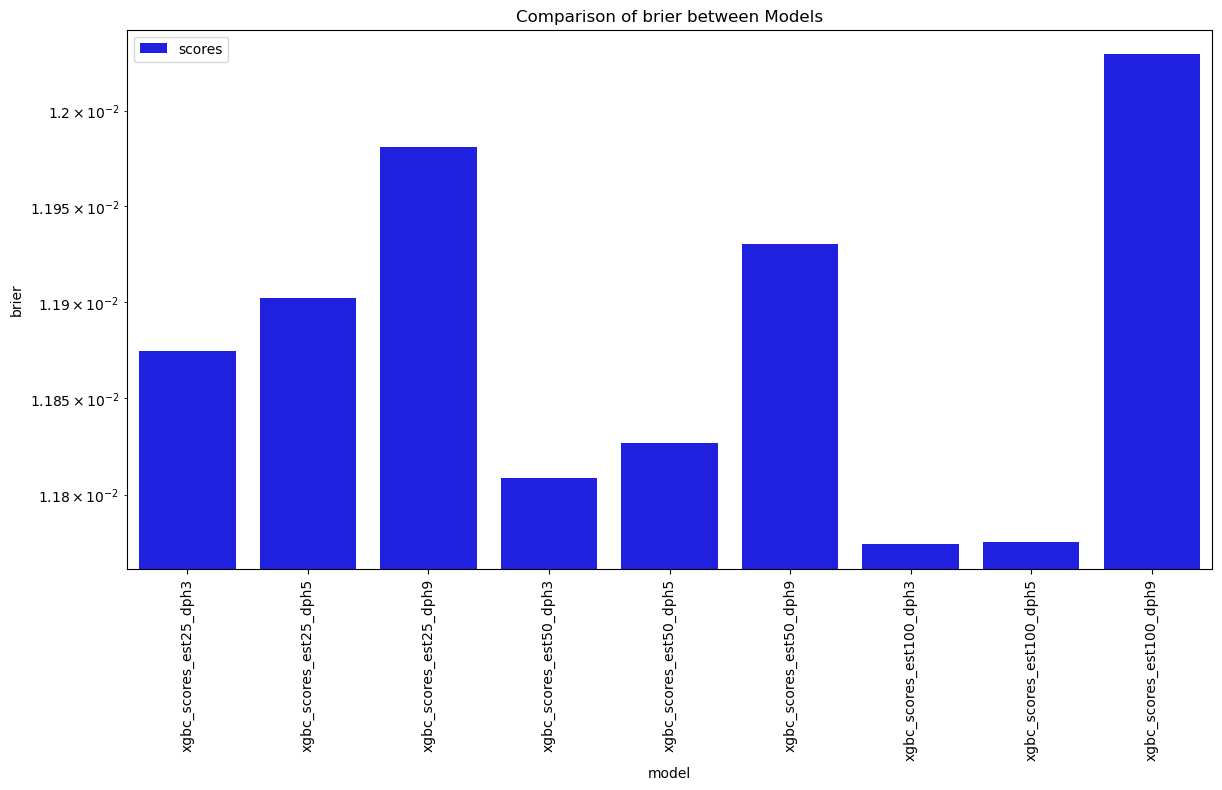

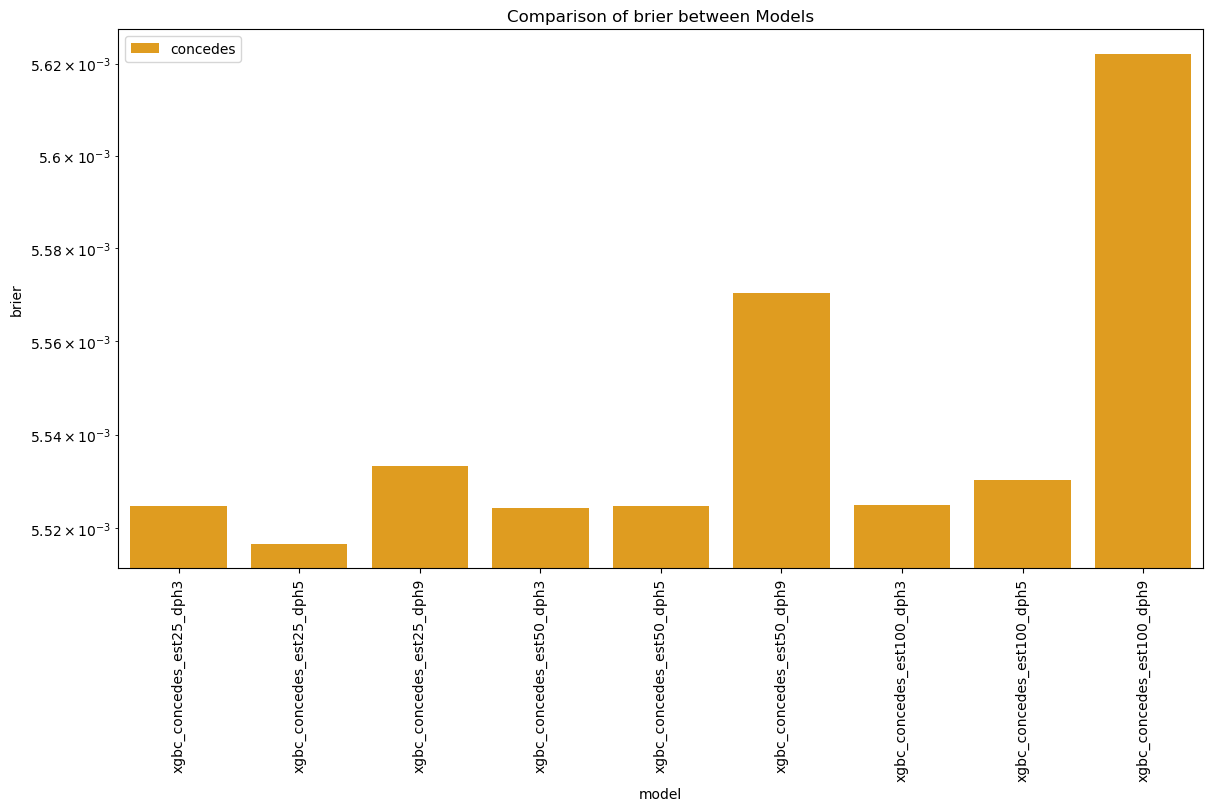

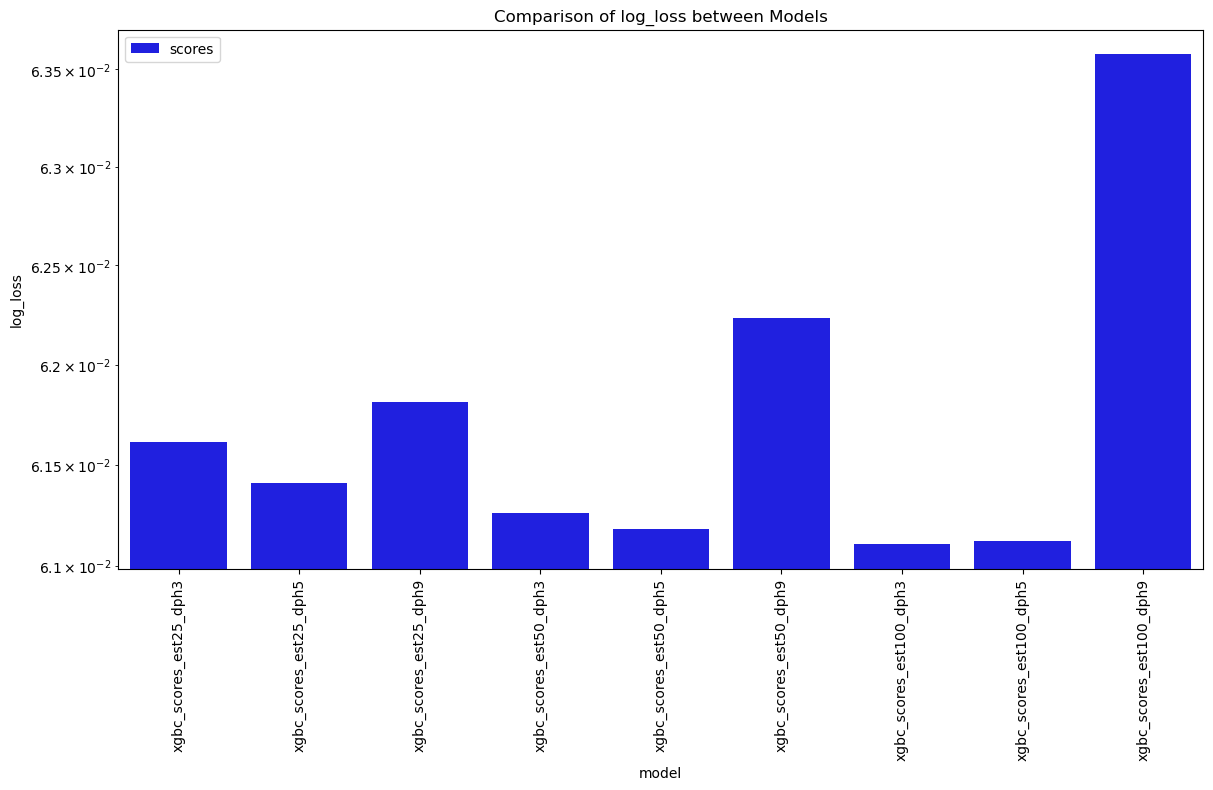

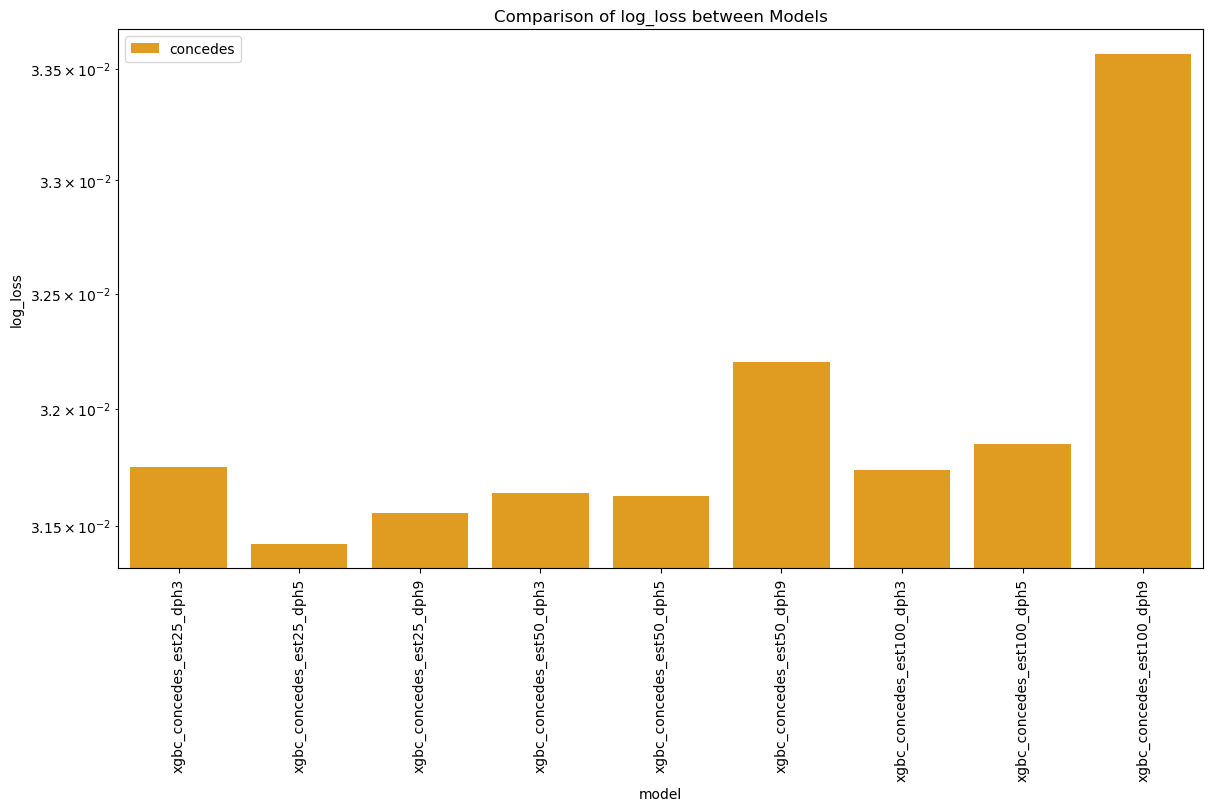

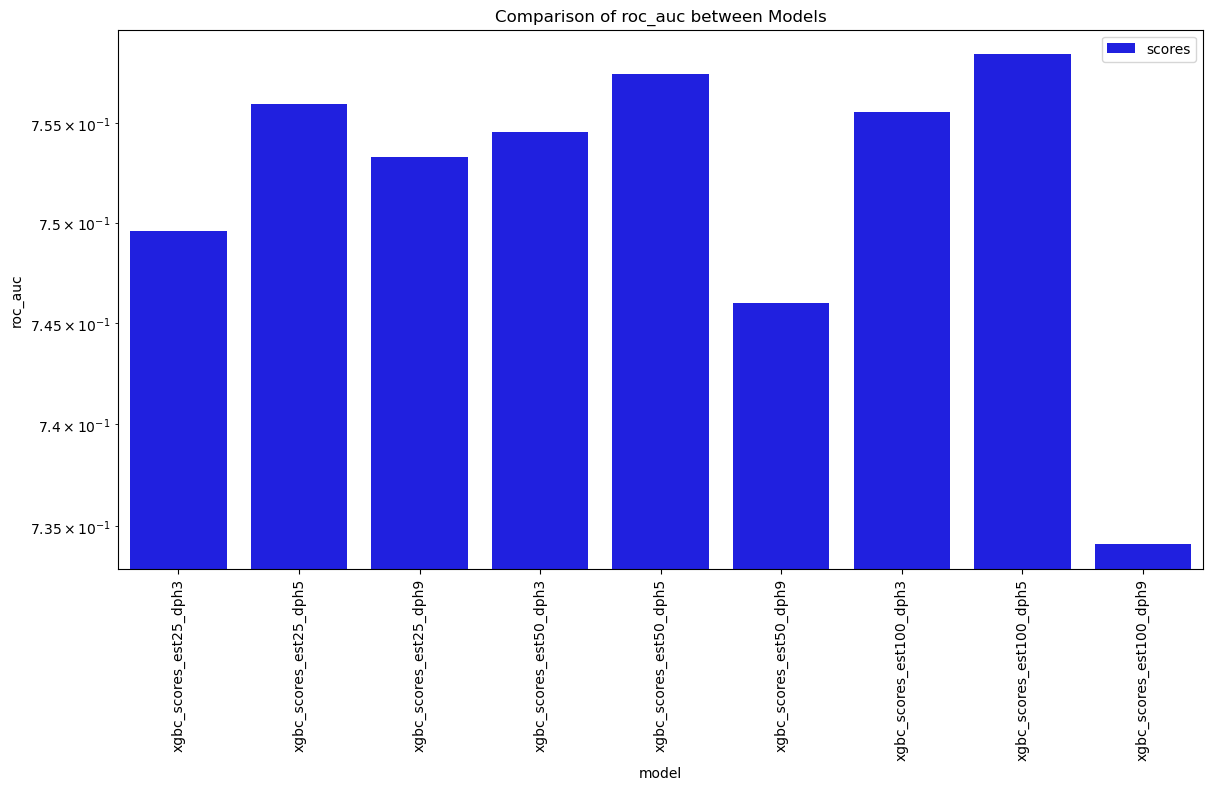

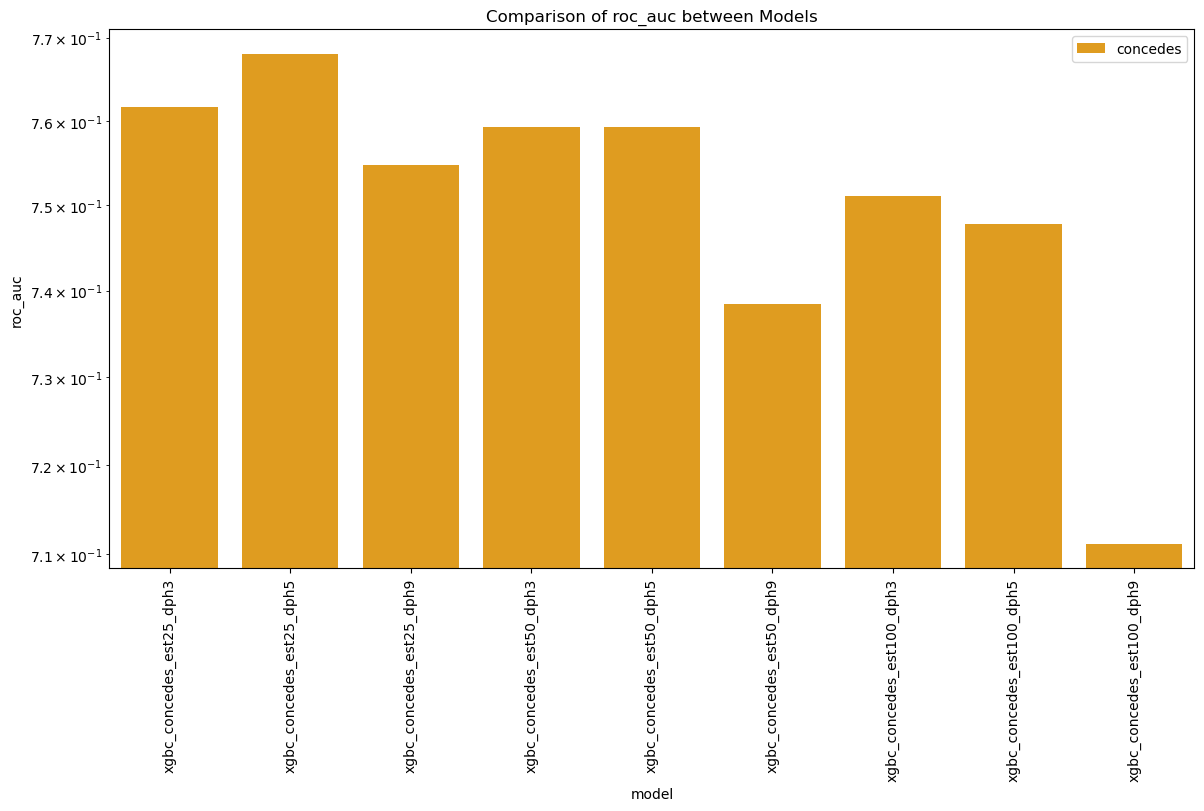

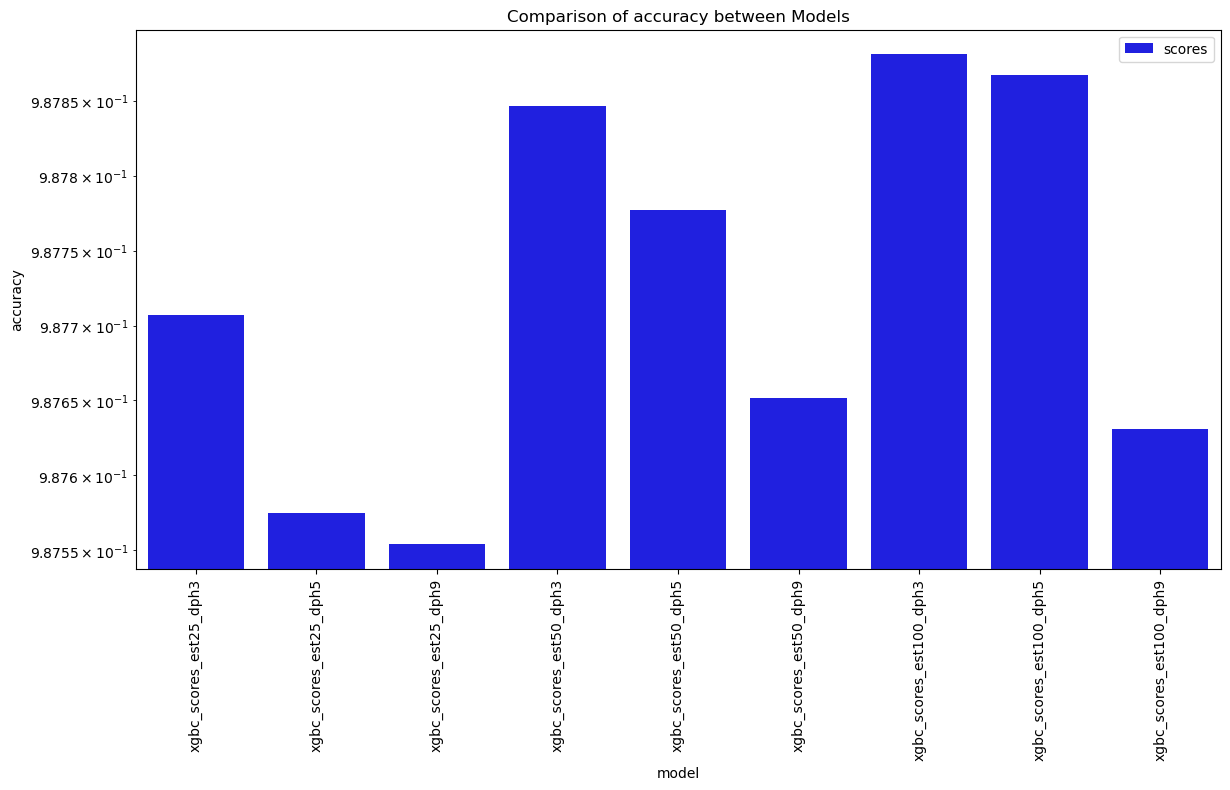

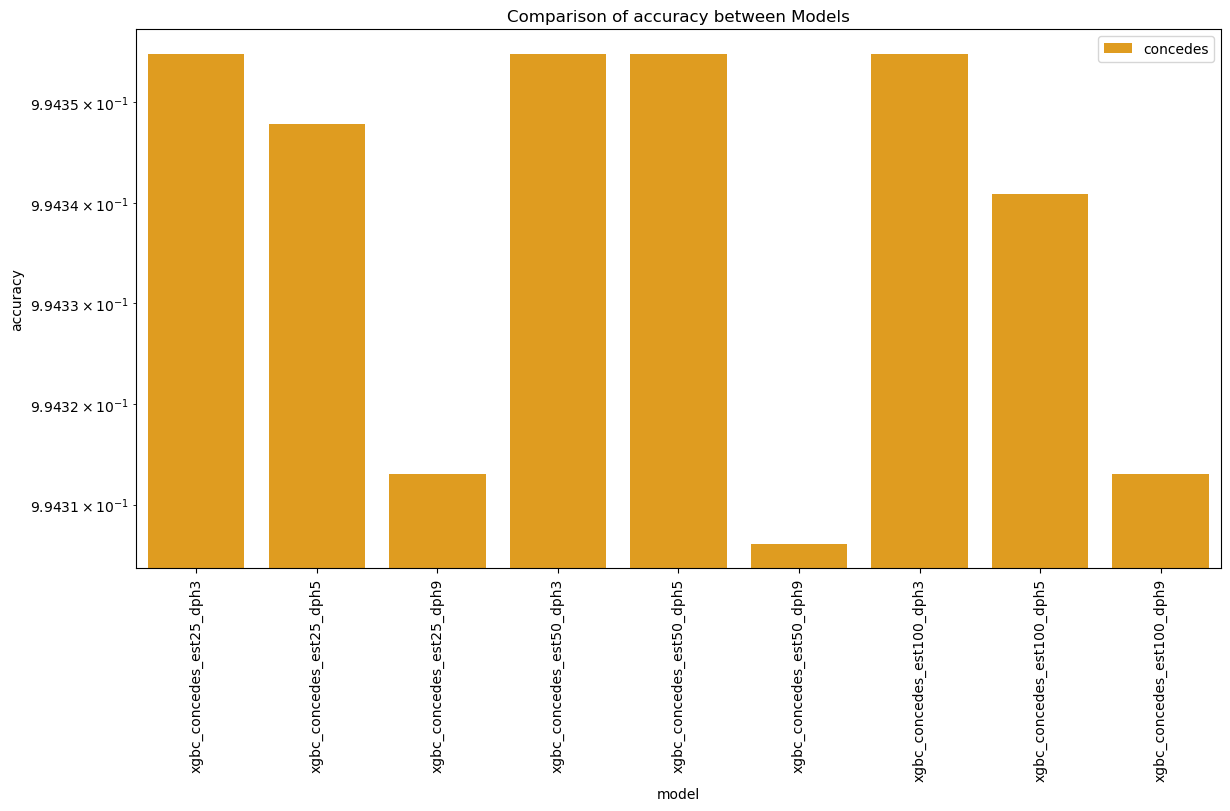

In [22]:
metrics = ["brier", "log_loss", "roc_auc", "accuracy"]

for metric in metrics:
    plot_metrics(scores_metrics, "scores", metric)
    plot_metrics(concedes_metrics, "concedes", metric)

In [23]:
metrics = ["brier", "log_loss", "roc_auc", "accuracy"]

for metric in metrics:
    ascending = True if metric=="brier" or metric=="log_loss" else False
    top3 = scores_metrics.sort_values(by=metric).reset_index(drop=True).head(3)
    print(f"Top 3 models for {metric}")
    print(top3['model'])

Top 3 models for brier
0    xgbc_scores_est100_dph3
1    xgbc_scores_est100_dph5
2     xgbc_scores_est50_dph3
Name: model, dtype: object
Top 3 models for log_loss
0    xgbc_scores_est100_dph3
1    xgbc_scores_est100_dph5
2     xgbc_scores_est50_dph5
Name: model, dtype: object
Top 3 models for roc_auc
0    xgbc_scores_est100_dph9
1     xgbc_scores_est50_dph9
2     xgbc_scores_est25_dph3
Name: model, dtype: object
Top 3 models for accuracy
0     xgbc_scores_est25_dph9
1     xgbc_scores_est25_dph5
2    xgbc_scores_est100_dph9
Name: model, dtype: object


In [24]:
metrics = ["brier", "log_loss", "roc_auc", "accuracy"]

for metric in metrics:
    ascending = True if metric=="brier" or metric=="log_loss" else False
    top3 = concedes_metrics.sort_values(by=metric).reset_index(drop=True).head(3)
    print(f"Top 3 models for {metric}")
    print(top3['model'])

Top 3 models for brier
0    xgbc_concedes_est25_dph5
1    xgbc_concedes_est50_dph3
2    xgbc_concedes_est50_dph5
Name: model, dtype: object
Top 3 models for log_loss
0    xgbc_concedes_est25_dph5
1    xgbc_concedes_est25_dph9
2    xgbc_concedes_est50_dph5
Name: model, dtype: object
Top 3 models for roc_auc
0    xgbc_concedes_est100_dph9
1     xgbc_concedes_est50_dph9
2    xgbc_concedes_est100_dph5
Name: model, dtype: object
Top 3 models for accuracy
0     xgbc_concedes_est50_dph9
1     xgbc_concedes_est25_dph9
2    xgbc_concedes_est100_dph9
Name: model, dtype: object


In [25]:
selected_params =  {
        "n_estimators": 100,
        "max_depth": 9,
        "n_jobs": -3,
        "verbosity": 1
}

models = {}
features = training_features.columns

features_df = pd.DataFrame()

for label in test_labels.columns:
        model_path = f"./models/xgbc_{label}_est{n_estimators}_dph{max_depth}.pkl"
        xgbc = XGBoostClassifier(n_estimators=n_estimators, max_depth=max_depth, n_jobs=n_jobs, verbosity=verbosity)
        xgbc.model.load_model(model_path)

        models[label] = xgbc

        metrics = xgbc.evaluate(test_features, test_labels[label])
        print(f"Metrics for {label}")
        print(metrics)

        print("##################################################################################")

        features_importance =  xgbc.model.feature_importances_
        
        feature_importance_df = pd.DataFrame({'label':label, 'feature': features, 'importance': features_importance})
        features_df = pd.concat([features_df, feature_importance_df])

Metrics for scores
{'brier': 0.012029845255237322, 'log_loss': 0.06357734266566166, 'roc_auc': 0.7341161094640815, 'accuracy': 0.9876306886998649}
##################################################################################
Metrics for concedes
{'brier': 0.005622072069374626, 'log_loss': 0.03356662358270177, 'roc_auc': 0.7111409783892237, 'accuracy': 0.9943130403307764}
##################################################################################


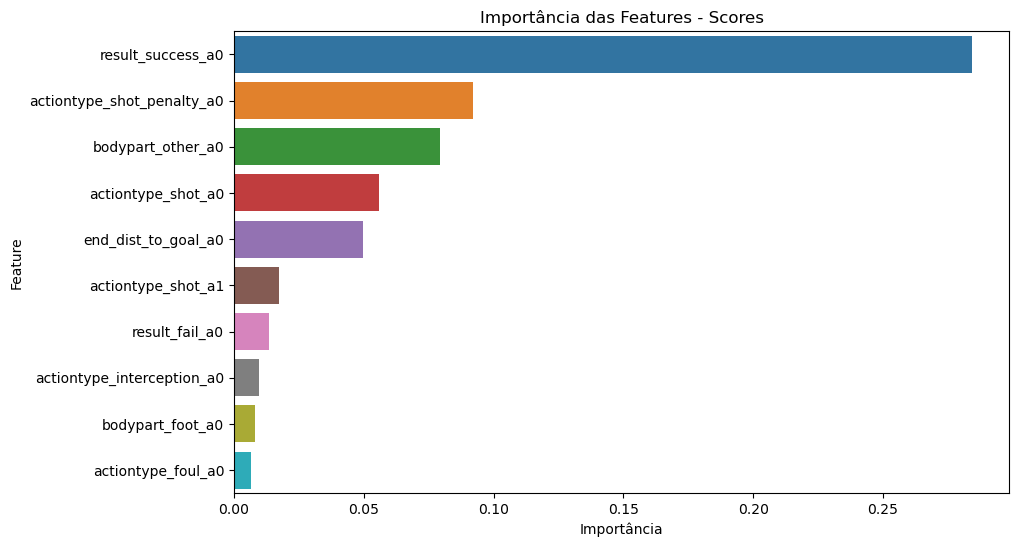

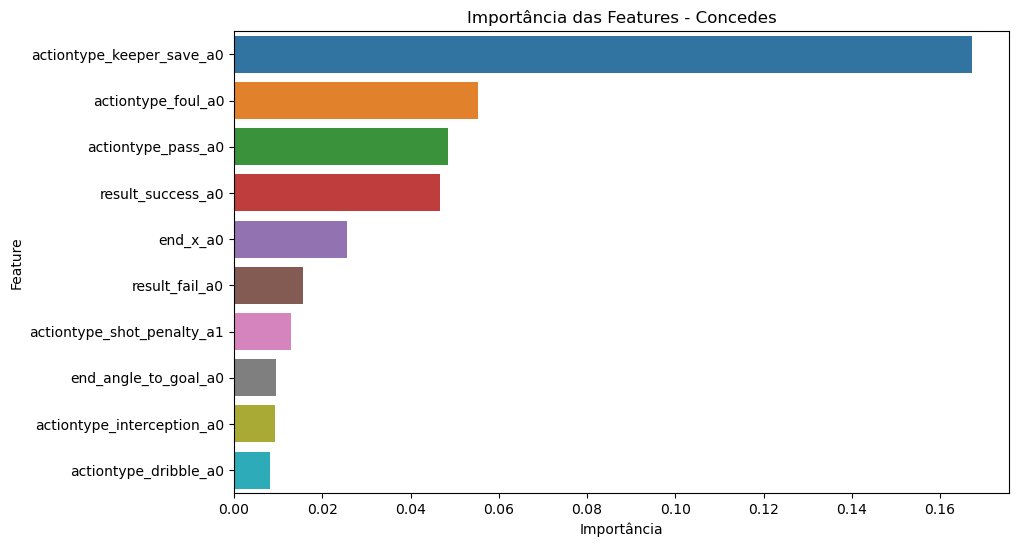

In [26]:
scores_df = features_df[features_df['label'] == 'scores']
concedes_df = features_df[features_df['label'] == 'concedes']

scores_df = scores_df.sort_values(by='importance', ascending=False)
concedes_df = concedes_df.sort_values(by='importance', ascending=False)

def plot_feature_importance(df, title):
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=df)
    plt.title(title)
    plt.xlabel('Importância')
    plt.ylabel('Feature')
    plt.show()

plot_feature_importance(scores_df.head(10), 'Importância das Features - Scores')
plot_feature_importance(concedes_df.head(10), 'Importância das Features - Concedes')

# Calculo do VAEP

In [27]:

def calculateVaep(models, actions):
    
    predictions = {}
    for model in tqdm(['scores', 'concedes'], desc="Predicting scores and concedes"):
        predictions[model] = models[model].predict_proba(test_features)[:, 0]
    
    predictions = pd.DataFrame(predictions)
    predictions = vaepformula.value(actions, predictions['scores'], predictions['concedes'])
    return predictions

In [28]:
preds = calculateVaep(models= models, actions=test_df)

actions_vaep = pd.concat([test_df, preds], axis=1).reset_index(drop=True)
actions_vaep = actions_vaep.sort_values(by=['game_id','period_id','time_seconds'])
actions_vaep

Predicting scores and concedes:   0%|          | 0/2 [00:00<?, ?it/s]

Predicting scores and concedes: 100%|██████████| 2/2 [00:00<00:00,  3.90it/s]


,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,...,type_id,result_id,action_id,type_name,result_name,bodypart_name,home_team_id,offensive_value,defensive_value,vaep_value
61509,1694390,1,1.255990,4418,26010,52.50,35.36,49.35,34.00,88178642,...,0,1,0,pass,success,foot,4418,0.001173,-0.000313,0.000860
61510,1694390,1,2.351908,4418,3682,49.35,34.00,43.05,35.36,88178643,...,0,1,1,pass,success,foot,4418,0.000366,0.000074,0.000440
61511,1694390,1,3.241028,4418,31528,43.05,35.36,33.60,44.20,88178644,...,0,1,2,pass,success,foot,4418,-0.000937,-0.002677,-0.003613
61512,1694390,1,6.033681,4418,7855,33.60,44.20,93.45,63.92,88178645,...,0,0,3,pass,fail,foot,4418,0.000068,0.002781,0.002849
61513,1694390,1,27.053006,4418,7915,89.25,68.00,97.65,57.12,88178648,...,2,0,4,throw_in,fail,other,4418,0.060735,-0.000350,0.060385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63866,2058017,2,2972.985039,9598,69968,36.75,68.00,48.30,54.40,263885651,...,2,1,1123,throw_in,success,other,4418,-0.008340,-0.000157,-0.008497
63867,2058017,2,2978.301867,9598,3476,48.30,54.40,67.20,63.92,263885652,...,0,1,1124,pass,success,foot,4418,-0.000249,-0.000341,-0.000591
63868,2058017,2,2980.875248,9598,14812,67.20,63.92,86.10,66.64,NaN,...,21,1,1125,dribble,success,foot,4418,0.007824,-0.001631,0.006193
63869,2058017,2,2983.448628,9598,14812,86.10,66.64,105.00,0.00,263885654,...,1,0,1126,cross,fail,foot_left,4418,-0.005797,0.001938,-0.003859


# Explorando os resultados

In [29]:
actions_vaep.sort_values(by='vaep_value', ascending=False).head(10)

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,...,type_id,result_id,action_id,type_name,result_name,bodypart_name,home_team_id,offensive_value,defensive_value,vaep_value
69743,2058012,4,554.377171,14358,41123,96.60,30.60,105.0,37.4,279011961,...,11,1,1518,shot,success,head/other,14358,0.826988,0.187199,1.014186
110085,2057987,2,2829.551092,14855,14911,80.85,17.68,105.0,37.4,259958556,...,11,1,1132,shot,success,foot_left,14855,0.983552,0.025404,1.008956
107454,2057993,2,1935.652394,17929,112679,94.50,31.28,105.0,30.6,260088494,...,11,1,929,shot,success,foot_right,2413,0.982120,0.026421,1.008541
63557,2058017,2,1389.182669,9598,14943,96.60,31.96,105.0,37.4,263885208,...,11,1,814,shot,success,foot_right,4418,0.995874,0.011233,1.007108
58859,1694397,2,1672.882598,2413,210044,86.10,32.64,105.0,37.4,88225841,...,13,1,939,shot_freekick,success,foot_right,2413,0.997780,-0.000545,0.997235
22848,1694424,2,87.098995,10451,101690,80.85,19.04,105.0,37.4,88950384,...,13,1,533,shot_freekick,success,foot_left,10451,0.997526,-0.001094,0.996432
77259,2058007,2,1434.673671,5629,48,97.65,49.64,105.0,30.6,261447152,...,11,1,1078,shot,success,head/other,5629,0.993838,0.001920,0.995759
43928,1694404,2,3049.534799,10962,9525,98.70,29.92,105.0,30.6,88594941,...,11,1,1107,shot,success,foot_right,14622,0.991836,0.003565,0.995401
130149,2057978,1,1147.300766,6380,3802,80.85,46.92,105.0,30.6,258973361,...,11,1,287,shot,success,foot_right,6380,0.992370,0.002922,0.995292
22516,1694424,1,1113.223365,10451,8372,81.90,42.16,105.0,30.6,88949633,...,11,1,201,shot,success,foot_left,10451,0.992614,0.002391,0.995005


In [30]:
actions_vaep.sort_values(by='offensive_value', ascending=False).head(10)

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,...,type_id,result_id,action_id,type_name,result_name,bodypart_name,home_team_id,offensive_value,defensive_value,vaep_value
58859,1694397,2,1672.882598,2413,210044,86.10,32.64,105.0,37.4,88225841,...,13,1,939,shot_freekick,success,foot_right,2413,0.997780,-0.000545,0.997235
22848,1694424,2,87.098995,10451,101690,80.85,19.04,105.0,37.4,88950384,...,13,1,533,shot_freekick,success,foot_left,10451,0.997526,-0.001094,0.996432
63557,2058017,2,1389.182669,9598,14943,96.60,31.96,105.0,37.4,263885208,...,11,1,814,shot,success,foot_right,4418,0.995874,0.011233,1.007108
125526,2057997,1,2291.058812,12430,91019,85.05,17.00,105.0,30.6,259350708,...,13,1,497,shot_freekick,success,foot_left,12430,0.995677,-0.008399,0.987278
103178,2057958,1,569.048270,15670,7972,86.10,36.04,105.0,30.6,260303912,...,13,1,103,shot_freekick,success,foot_right,15670,0.995567,-0.002623,0.992944
51397,1694415,1,1864.907916,3757,20468,96.60,38.76,105.0,30.6,88369883,...,11,1,469,shot,success,foot_right,5629,0.995504,-0.000582,0.994922
77259,2058007,2,1434.673671,5629,48,97.65,49.64,105.0,30.6,261447152,...,11,1,1078,shot,success,head/other,5629,0.993838,0.001920,0.995759
33657,1694395,1,2575.526464,8731,50461,103.95,41.48,105.0,30.6,88743642,...,11,1,614,shot,success,head/other,11944,0.993297,-0.000301,0.992996
65374,2058015,1,285.674094,2413,8945,78.75,27.20,105.0,30.6,263153952,...,13,1,43,shot_freekick,success,foot_right,9598,0.993059,-0.001479,0.991580
136261,2057972,1,1120.727608,12274,8325,90.30,42.16,105.0,37.4,258757815,...,11,1,262,shot,success,foot_left,12274,0.992632,0.000146,0.992777


In [31]:
actions_vaep.sort_values(by='offensive_value', ascending=True).head(10)

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,...,type_id,result_id,action_id,type_name,result_name,bodypart_name,home_team_id,offensive_value,defensive_value,vaep_value
69814,2058012,5,14.816089,9598,135747,94.50,33.32,94.5,33.32,279012171,...,14,1,1589,keeper_save,success,other,14358,-0.919494,-0.364586,-1.284080
80404,2058005,5,93.443391,9598,69400,93.45,34.00,0.0,68.00,261268841,...,12,0,1645,shot_penalty,fail,foot_right,9598,-0.792278,-0.001263,-0.793541
7192,1694436,5,135.445243,3148,14732,94.50,34.00,0.0,68.00,89883744,...,12,0,1725,shot_penalty,fail,foot_right,3148,-0.792230,-0.000582,-0.792812
69819,2058012,5,192.497716,14358,41123,93.45,34.00,0.0,68.00,279012178,...,12,0,1594,shot_penalty,fail,foot_right,14358,-0.792124,-0.001111,-0.793235
80412,2058005,5,412.200078,9598,69964,93.45,34.00,0.0,68.00,261268847,...,12,0,1653,shot_penalty,fail,foot_left,9598,-0.791675,-0.000958,-0.792633
82219,2058004,5,21.336988,1598,3353,10.50,34.00,0.0,68.00,280217501,...,12,1,1802,shot_penalty,success,foot_right,1598,-0.791598,-0.042695,-0.834294
69813,2058012,5,13.555301,14358,101707,94.50,33.32,0.0,68.00,279012170,...,12,0,1588,shot_penalty,fail,foot_right,14358,-0.791542,-0.957210,-1.748752
80414,2058005,5,464.505778,7712,15080,10.50,34.00,105.0,0.00,261268688,...,12,0,1655,shot_penalty,fail,foot_right,9598,-0.791528,-0.150719,-0.942247
7201,1694436,5,378.987215,3148,14728,93.45,34.68,0.0,68.00,89883755,...,12,0,1734,shot_penalty,fail,foot_right,3148,-0.790993,-0.002099,-0.793092
69817,2058012,5,146.319811,9598,69404,11.55,34.00,105.0,0.00,279012176,...,12,0,1592,shot_penalty,fail,foot_right,14358,-0.789828,-0.066959,-0.856787


In [32]:
actions_vaep.sort_values(by='defensive_value', ascending=False).head(10)

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,...,type_id,result_id,action_id,type_name,result_name,bodypart_name,home_team_id,offensive_value,defensive_value,vaep_value
10085,1694434,5,355.062425,9905,70134,93.45,34.68,93.45,34.68,89754126,...,14,1,1660,keeper_save,success,other,13869,0.017964,0.627573,0.645537
102821,2057959,2,1873.694108,16521,122940,8.40,29.24,0.00,21.76,260309743,...,10,1,1103,interception,success,foot,16521,-0.001882,0.614574,0.612692
13780,1694430,1,777.512966,14496,78488,94.50,34.00,94.50,34.00,89280403,...,14,1,142,keeper_save,success,other,3148,0.002767,0.514531,0.517298
36682,1694422,2,2843.625479,10451,101690,14.70,64.60,70.35,57.12,88689768,...,18,0,1188,clearance,fail,foot,7839,0.000056,0.514379,0.514435
93133,2057988,1,98.984958,3148,134383,10.50,34.00,63.00,49.64,260662155,...,18,0,24,clearance,fail,foot,14855,0.000989,0.441240,0.442229
58549,1694397,2,191.459670,2413,7887,5.25,36.72,4.20,36.72,88225383,...,0,1,629,pass,success,foot,2413,-0.000608,0.422827,0.422220
44342,1694399,1,1901.838743,10682,136441,6.30,37.40,6.30,37.40,88585582,...,10,1,413,interception,success,foot,2413,-0.001790,0.419164,0.417374
2211,1694439,1,1907.138479,4418,25804,11.55,25.16,53.55,0.00,90357033,...,18,0,517,clearance,fail,foot,3148,0.000288,0.412453,0.412741
55262,1694403,2,735.431380,3148,14732,3.15,35.36,3.15,31.28,88280349,...,0,1,777,pass,success,foot,3148,-0.000098,0.345057,0.344960
1959,1694439,1,955.567660,4418,25804,27.30,2.72,35.70,10.88,90356758,...,0,1,265,pass,success,foot,3148,0.009232,0.323743,0.332976


In [33]:
actions_vaep.sort_values(by='defensive_value', ascending=True).head(10)

,game_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,original_event_id,...,type_id,result_id,action_id,type_name,result_name,bodypart_name,home_team_id,offensive_value,defensive_value,vaep_value
69813,2058012,5,13.555301,14358,101707,94.50,33.32,0.00,68.00,279012170,...,12,0,1588,shot_penalty,fail,foot_right,14358,-0.791542,-0.957210,-1.748752
6581,1694436,2,1877.708839,3148,14716,9.45,44.88,9.45,44.88,89883005,...,8,0,1114,foul,fail,other,3148,0.002160,-0.866669,-0.864509
14967,1694429,1,391.438986,8274,8624,14.70,17.68,14.70,17.68,89269913,...,8,0,76,foul,fail,other,4418,-0.000994,-0.832038,-0.833032
95113,2057976,2,202.167540,12274,3355,4.20,27.88,4.20,27.88,260554928,...,8,4,648,foul,yellow_card,foot,16823,0.000245,-0.829614,-0.829368
96655,2057977,2,1751.999822,9598,25393,10.50,22.44,10.50,22.44,260553345,...,8,0,991,foul,fail,other,7839,-0.004255,-0.816195,-0.820450
113412,2057975,2,2057.878249,16823,332821,6.30,48.96,6.30,48.96,259858403,...,8,0,929,foul,fail,foot,16823,-0.004204,-0.778426,-0.782631
138636,2057960,1,134.996277,1598,3304,10.50,17.68,10.50,17.68,258700886,...,8,0,46,foul,fail,foot,9905,0.000115,-0.775039,-0.774924
2365,1694439,1,2722.473247,3148,14728,11.55,38.08,11.55,38.08,90357328,...,8,4,671,foul,yellow_card,other,3148,-0.000003,-0.770507,-0.770510
46522,1694392,1,1027.460864,6697,20465,12.60,20.40,12.60,20.40,88520350,...,8,0,284,foul,fail,foot,11944,0.001402,-0.768904,-0.767502
101328,2057964,2,266.429754,10840,241647,14.70,31.28,14.70,31.28,260342171,...,8,0,707,foul,fail,foot,10840,0.003443,-0.765900,-0.762456


In [34]:
df_vaep = actions_vaep[['game_id','type_name','team_id', 'player_id','vaep_value', 'offensive_value', 'defensive_value']]
df_vaep

,game_id,type_name,team_id,player_id,vaep_value,offensive_value,defensive_value
61509,1694390,pass,4418,26010,0.000860,0.001173,-0.000313
61510,1694390,pass,4418,3682,0.000440,0.000366,0.000074
61511,1694390,pass,4418,31528,-0.003613,-0.000937,-0.002677
61512,1694390,pass,4418,7855,0.002849,0.000068,0.002781
61513,1694390,throw_in,4418,7915,0.060385,0.060735,-0.000350
...,...,...,...,...,...,...,...
63866,2058017,throw_in,9598,69968,-0.008497,-0.008340,-0.000157
63867,2058017,pass,9598,3476,-0.000591,-0.000249,-0.000341
63868,2058017,dribble,9598,14812,0.006193,0.007824,-0.001631
63869,2058017,cross,9598,14812,-0.003859,-0.005797,0.001938


In [35]:
vaep_players = df_vaep.groupby(['player_id','team_id']).sum().reset_index()

vaep_players = vaep_players.merge(players, how='left', on='player_id', suffixes=('', '_player'))
vaep_players = vaep_players.drop(columns=['team_id_player'])

game_counts = df_vaep.groupby('player_id')['game_id'].nunique().reset_index()
game_counts = game_counts.rename(columns={'game_id': 'games_played'})

vaep_players = pd.merge(vaep_players, game_counts, on='player_id')

vaep_players['vaep_per_game'] = vaep_players['vaep_value'] / vaep_players['games_played']

vaep_players = vaep_players.sort_values(by=['vaep_per_game','vaep_value'], ascending=False).reset_index(drop=True)
vaep_players[vaep_players['games_played'] > 5].head(10)

,player_id,team_id,game_id,type_name,vaep_value,offensive_value,defensive_value,player_name,shortName,player_country,train_age,test_age,games_played,vaep_per_game
12,353833,4418,526846616,shotpasspassfreekick_crossedpasstake_ontake_on...,4.231449,4.192481,0.038968,Kylian Mbappé Lottin,K. Mbappé,Cameroon,18,17,7,0.604493
15,3682,4418,1256937492,passpasstackleshotpassdribblepasspassshotpassp...,8.344785,7.831927,0.512858,Antoine Griezmann,A. Griezmann,France,26,25,14,0.596056
25,25714,4418,725209707,interceptiontake_onpasspasspasspasspasspasspas...,3.734370,3.702405,0.031965,Dimitri Payet,D. Payet,France,30,29,7,0.533481
26,8278,10682,576102625,dribblepasstake_onpassinterceptionclearancepas...,3.194571,3.219448,-0.024878,Gareth Frank Bale,G. Bale,Wales,28,26,6,0.532428
27,14723,3148,2079603066,passpasspasspasspasspassdribblepasspasspasstak...,4.699485,4.648378,0.051107,Toni Kroos,T. Kroos,Germany,27,26,9,0.522165
30,25707,5629,1481729562,passpassdribblepasspasspassdribbletake_onpassp...,5.568809,5.434537,0.134272,Eden Hazard,E. Hazard,Belgium,26,25,11,0.506255
39,340646,4418,858183103,throw_inpasspasspasspasspasspasspassdribblepas...,2.744658,2.365879,0.378779,Benjamin Pavard,B. Pavard,France,21,20,6,0.457443
41,3319,3148,1275148390,passpasspasspasspasspasspasspasspasspasspasspa...,3.533180,3.820131,-0.286951,Mesut Özil,M. Özil,Germany,28,27,8,0.441647
46,49872,6697,992325811,passpasspasscorner_crosseddribblepasscorner_sh...,3.449743,3.891664,-0.441921,Xherdan Shaqiri,X. Shaqiri,Switzerland,25,24,8,0.431218
47,14812,9598,947810435,passdribblepasspasspasspasscrossdribbletacklef...,4.680358,4.702355,-0.021997,Ivan Perišić,I. Perišić,Croatia,28,27,11,0.425487


In [36]:
vaep_teams = df_vaep.groupby(['team_id']).sum().reset_index()

vaep_teams = vaep_teams.merge(teams, how='left', on='team_id', suffixes=('', '_team'))
#vaep_teams = vaep_teams.drop(columns=['team_id_team'])

game_counts = df_vaep.groupby('team_id')['game_id'].nunique().reset_index()
game_counts = game_counts.rename(columns={'game_id': 'games_played'})

vaep_teams = pd.merge(vaep_teams, game_counts, on='team_id')

vaep_teams['vaep_per_game'] = vaep_teams['vaep_value'] / vaep_teams['games_played']

vaep_teams = vaep_teams.sort_values(by=['vaep_per_game','vaep_value'], ascending=False).reset_index(drop=True)
vaep_teams[vaep_teams['games_played'] > 5].head(10)

,team_id,game_id,type_name,player_id,vaep_value,offensive_value,defensive_value,team_name,team_country,games_played,vaep_per_game
1,5629,15242610706,throw_inpasspasspasspasspasspasscrossthrow_inp...,253040667,37.059590,33.622144,3.437446,Belgium,Belgium,12,3.088299
2,4418,16884021583,passpasspasspassthrow_inshotclearanceintercept...,601392302,35.753618,35.058064,0.695554,France,France,14,2.553830
3,10682,5735602845,passpassinterceptionpasspasspasspasspasspasspa...,143258866,14.978860,13.141561,1.837299,Wales,Wales,6,2.496477
7,2413,14796495169,passpasspasspassfreekick_shortpasspasspasspass...,291639213,23.709504,23.644794,0.064711,England,England,11,2.155409
12,7839,6289206159,passpasspasspasspasspasspasspasspasspassdribbl...,190324235,15.260532,13.495312,1.765219,Iceland,Iceland,8,1.907566
13,9905,13860028132,passdribbletake_onpasspasspasspasspassintercep...,458444553,20.747661,21.364040,-0.616379,Portugal,Portugal,11,1.886151
15,9598,15125030888,throw_inpasspasspassdribblepasspassthrow_inpas...,443140376,20.599240,21.382177,-0.782937,Croatia,Croatia,11,1.872658
16,1598,13885467315,passpassinterceptionpasspasspasspasspasspasspa...,63756146,14.785116,16.108419,-1.323303,Spain,Spain,8,1.848140
17,3148,13911811828,passpasspasspasspasspassinterceptionpasspasspa...,284513773,16.551604,17.636246,-1.084642,Germany,Germany,9,1.839067
19,14358,8784155412,passfoulpasspasspassinterceptionpasspassthrow_...,494239017,14.148550,14.614646,-0.466097,Russia,Russia,8,1.768569


In [37]:
vaep_actions = df_vaep.groupby(['type_name']).sum().reset_index()

action_counts = df_vaep.groupby('type_name').size().reset_index(name='action_count')
vaep_actions = pd.merge(vaep_actions, action_counts, on='type_name')

vaep_actions['vaep_per_game'] = vaep_actions['vaep_value'] / vaep_actions['action_count']

vaep_actions = vaep_actions.sort_values(by=['vaep_per_game','vaep_value'], ascending=False).reset_index(drop=True)
vaep_actions[vaep_teams['games_played'] > 5].head(10)

C:\Users\jllgo\AppData\Local\Temp\ipykernel_58160\1726840416.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  vaep_actions[vaep_teams['games_played'] > 5].head(10)


,type_name,game_id,team_id,player_id,vaep_value,offensive_value,defensive_value,action_count,vaep_per_game
1,shot,4950193654,23470713,162340520,104.814327,107.114188,-2.299860,2617,0.040051
2,freekick_crossed,975397682,4821670,32315963,17.318386,19.029307,-1.710921,513,0.033759
3,dribble,17686167677,87867543,685599785,52.453239,45.114706,7.338533,9205,0.005698
7,take_on,5323528385,26695438,227903665,10.990491,12.136680,-1.146189,2800,0.003925
12,bad_touch,29779072,181745,1848842,0.023266,-0.003568,0.026834,15,0.001551
13,tackle,2016978698,10938985,80080598,-2.471820,-3.013635,0.541815,1073,-0.002304
15,corner_crossed,1607248968,7439847,47999174,-8.236774,-5.384232,-2.852542,852,-0.009668
16,corner_short,535146026,2468788,18543653,-5.051066,-4.539633,-0.511434,283,-0.017848
17,foul,5700354381,30017115,223460237,-55.856870,-20.217771,-35.639099,2996,-0.018644
